실내데이터(1층 실습실) ARIMA

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

In [2]:
df = pd.read_csv('1floor.csv', encoding='cp949')

In [3]:
df1 = df

In [4]:
#전처리과정
df = df.rename(columns={'field1':'temperature'})
df = df.rename(columns={'field2':'humidity'})
df = df.rename(columns={'field3':'co2'})
df = df.rename(columns={'field4':'pm1'})
df = df.rename(columns={'field5':'pm2.5'})
df = df.rename(columns={'field6':'pm10'})

In [5]:
df = df.drop('entry_id', axis=1)
df = df.iloc[:, :7]

In [6]:
df.head()

,created_at,temperature,humidity,co2,pm1,pm2.5,pm10
0,2019-05-10 06:29:50 UTC,24,NaN,NaN,NaN,NaN,NaN
1,2019-05-10 06:35:54 UTC,24,NaN,NaN,NaN,NaN,NaN
2,2019-05-10 06:46:00 UTC,24,NaN,NaN,NaN,NaN,NaN
3,2019-05-10 06:54:42 UTC,25,42.0,909.0,36.0,51.0,61.0
4,2019-05-10 07:03:56 UTC,25,43.0,844.0,37.0,50.0,53.0


In [7]:
df = df.replace("-", np.nan)
df = df.dropna(axis=0)
df.iloc[:,1:] = df.iloc[:,1:].astype(str).astype(float)

In [8]:
for i in range(1, len(df)):
    if (df.iloc[i,4]>df.iloc[i-1,4]+30) or (df.iloc[i, 4] > 200):
        df.iloc[i, 4]=df.iloc[i-1, 4]
    if (df.iloc[i,5]>df.iloc[i-1,5]+30) or (df.iloc[i, 5] > 200):
        df.iloc[i, 5]=df.iloc[i-1, 5]
    if (df.iloc[i,6]>df.iloc[i-1,6]+30) or (df.iloc[i, 6] > 200):
        df.iloc[i, 6]=df.iloc[i-1, 6]

In [9]:
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.set_index('created_at', inplace=False)

In [10]:
df.tail()

,temperature,humidity,co2,pm1,pm2.5,pm10
created_at,,,,,,
2019-06-01 06:47:47,23.0,53.0,545.0,7.0,8.0,10.0
2019-06-01 06:52:28,23.0,54.0,555.0,6.0,7.0,9.0
2019-06-01 06:57:09,23.0,54.0,575.0,7.0,10.0,10.0
2019-06-01 07:01:51,23.0,53.0,583.0,6.0,12.0,13.0
2019-06-01 07:06:32,23.0,54.0,577.0,8.0,11.0,12.0


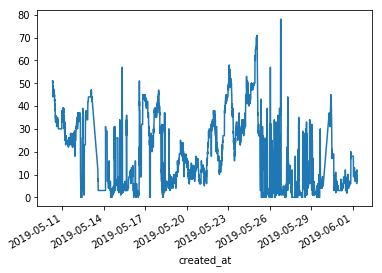

In [11]:
df['pm2.5'].plot()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6248 entries, 2019-05-10 06:54:42 to 2019-06-01 07:06:32
Data columns (total 6 columns):
temperature    6248 non-null float64
humidity       6248 non-null float64
co2            6248 non-null float64
pm1            6248 non-null float64
pm2.5          6248 non-null float64
pm10           6248 non-null float64
dtypes: float64(6)
memory usage: 341.7 KB


In [74]:
#예측할 데이터들 따로 빼기 - pm10 사용 // 약 250개 예측
df1 = df.iloc[:6240, 5]
test = df.iloc[6240:,5]

In [51]:
from pmdarima.arima import auto_arima

In [62]:
stepwise_fit = auto_arima(df1, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise
stepwise_fit.fit(df1)
stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=34944.417, BIC=34971.371, Fit time=1.467 seconds
Fit ARIMA: order=(0, 1, 0); AIC=35051.515, BIC=35064.992, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=35046.909, BIC=35067.125, Fit time=0.047 seconds
Fit ARIMA: order=(0, 1, 1); AIC=35046.185, BIC=35066.400, Fit time=0.046 seconds
Fit ARIMA: order=(2, 1, 1); AIC=34946.260, BIC=34979.953, Fit time=1.752 seconds
Fit ARIMA: order=(1, 1, 2); AIC=34946.254, BIC=34979.947, Fit time=1.957 seconds
Fit ARIMA: order=(2, 1, 2); AIC=34945.878, BIC=34986.309, Fit time=2.748 seconds
Total fit time: 8.025 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 6239
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17468.208
Method:                       css-mle   S.D. of innovations              3.978
Date:                Sat, 01 Jun 2019   AIC                          34944.417
Time:                        16:29:38   BIC                          34971.371
Sample:                             1   HQIC                         34953.759
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068      0.018     -0.377      0.707      -0.042       0.029
ar.L1.D.y      0.9163      0.021     43.128      0.000       0.875       0.958
ma.L1.D.y     -0.9701      0.014    -67.713      0.000      -0.998      -0.942
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0913           +0.0000j            1.0913            0.0000
MA.1            1.0309           +0.0000j            1.0309            0.0000
-----------------------------------------------------------------------------
"""

In [16]:
from statsmodels.tsa.arima_model import ARIMA

In [75]:
model = ARIMA(df1, order=(1,1,1))
model_fit = model.fit(trend='c',full_output=True, disp=False)
print(model_fit.summary())

C:\Users\HanSung\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\HanSung\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.pm10   No. Observations:                 6239
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17468.208
Method:                       css-mle   S.D. of innovations              3.978
Date:                Sat, 01 Jun 2019   AIC                          34944.417
Time:                        16:30:43   BIC                          34971.371
Sample:                             1   HQIC                         34953.759
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0068      0.018     -0.377      0.707      -0.042       0.029
ar.L1.D.pm10     0.9163      0.021     43.128      0.000       0.875       0.958
ma.L1.D.pm10    -0.9701      0.014    -67.71

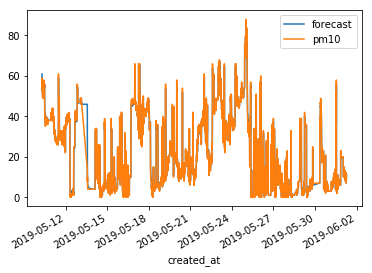

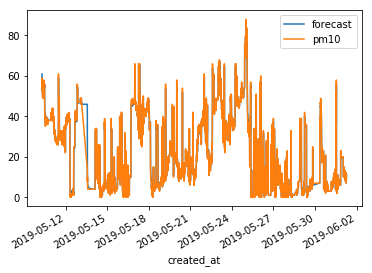

In [76]:
model_fit.plot_predict()

In [77]:
forecast = model_fit.forecast(steps=8)
fore = forecast[0]

In [70]:
forecast[2]

array([[ 1.31202537, 16.90708948],
       [-1.5258554 , 19.94461386],
       [-3.51265711, 22.11321694],
       [-5.04960229, 23.81561396],
       [-6.29772194, 25.21420373],
       [-7.3421155 , 26.39533912],
       [-8.23458538, 27.41197105],
       [-9.00952272, 28.29954312]])

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [78]:
rmse = sqrt(mean_squared_error(test, fore))
print('Test RMSE : %.3f' %rmse)

Test RMSE : 1.723


In [79]:
n = df1.shape[0]
d = np.abs(np.diff(df1)).sum()/(n-1)
err = np.abs(test - fore)
mase = err.mean()/d
print('Test MASE : %.3f' %mase)

Test MASE : 1.026


In [80]:
df1 = pd.DataFrame(df1)
fore = pd.DataFrame(fore)
test = pd.DataFrame(test)
fore.columns = ["predict"]
fore = fore.set_index(test.index)

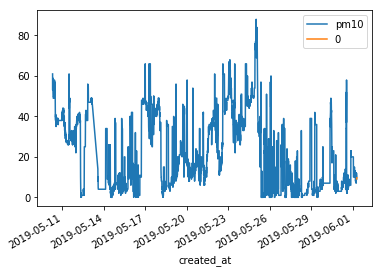

In [81]:
pd.concat([df1, fore], axis=1).plot()

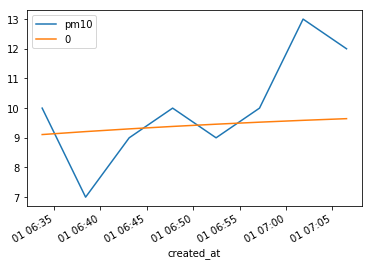

In [82]:
pd.concat([test, fore], axis=1).plot()